# Training on derivative values

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from functools import partial

import jax
import jax.numpy as jnp

import gpx
from gpx.models import GPR
from gpx.parameters import Parameter
from gpx.bijectors import Softplus
from gpx.priors import GammaPrior


import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('dark_background')

## Simple Example

This example illustrates how to train with on derivative values only (e.g., forces), also taking into account a transformation of the original input (e.g., computing a descriptor).

We use a fairly simple example just to understand how things work.
We take our original $x$ to be one-dimensional. The $y = f(x)$ is computed as a combination of sine and cosine functions of $x$

$$f(x) = \sin(x) - 2 \cos(x)$$

We take 20 values for $x$. The jacobian of $f(x)$ is computed automatically with JAX.

In [3]:
# 20 values equally spaced between -3 and 3
x = jnp.linspace(-3, 3, 20).reshape(-1, 1)

# f(x) for a single point
def f(x):
    return 1.0 * jnp.sin(x) - 2.0 * jnp.cos(x)

# df/dx 
df_dx = jax.jacrev(f)

# f(x) and its gradient functions, but working on a batch of points
f_batched = jax.vmap(f)
df_dx_batched = jax.vmap(df_dx)

print('f_batched(x).shape =', f_batched(x).shape)

print('df_dx_batched(x).shape =', df_dx_batched(x).shape)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


f_batched(x).shape = (20, 1)
df_dx_batched(x).shape = (20, 1, 1)


Note the shape of the jacobian, which is: (number of samples, number of features, number of derivative values).

We can plot the function and its derivative

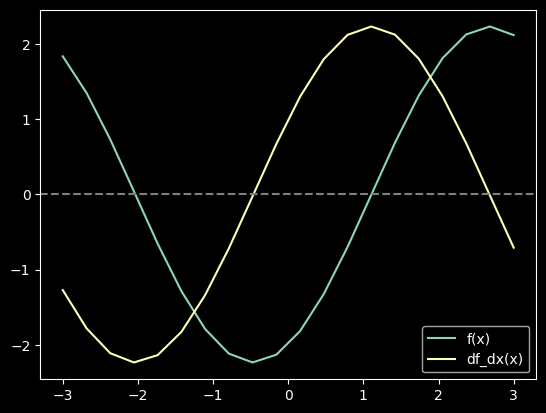

In [4]:
plt.plot(x, f_batched(x), label='f(x)')
plt.plot(x, df_dx_batched(x).squeeze(), label='df_dx(x)')
plt.axhline(0, ls='dashed', c='gray')
plt.legend()

## Computing the descriptor and its Jacobian

We choose a descriptor $d(x)$ for $x$ as bidimensional (just to play with a different number of dimensions), as follows:

$$d(x) = \left[ \sin(x), \cos(x) \right]$$

and compute its jacobian automatically with JAX

In [5]:
# for a single point
def d(x):
    return jnp.array([jnp.sin(x), jnp.cos(x)]).squeeze()

# dd_dx for a single point
dd_dx = jax.jacrev(d)

# functions for a batch of points
d_batched = jax.vmap(d)
dd_dx_batched = jax.vmap(dd_dx)

print('d_batched(x).shape =', d_batched(x).shape)
print('dd_dx_batched(x).shape =', dd_dx_batched(x).shape)

d_batched(x).shape = (20, 2)
dd_dx_batched(x).shape = (20, 2, 1)


Let's compute everything and ensure it has the correct dimension

In [6]:
# y must be (n_samples, 1)
y = df_dx_batched(x).squeeze().reshape(-1, 1)
print('y.shape =', y.shape)

# d must be (n_samples, n_features)
d = d_batched(x)
print('d.shape =', d.shape)

# jacobian of d must be (n_samples, n_features, n_dims_x)
jac_d = dd_dx_batched(x)
print('jac_d.shape = ', jac_d.shape)

y.shape = (20, 1)
d.shape = (20, 2)
jac_d.shape =  (20, 2, 1)


## Computing the derivative kernel

At this point we can instantiate the model.
As we are training on derivative values, we need a specialized kernel for that.
In particular, we must use the following kernel:

$$\nabla_{x} \nabla_{y} k(x, y)$$

i.e., the kernel derived w.r.t. its first and its second argument.
`GPX` provides a convenience `kernelizer` function for that.
In general, a `kernelizer` takes as input a kernel function $k(x, y)$, evaluating a single element of the kernel, and provides another function that works on a batch of points to construct a kernel of dimensions $N \times  N$, where $N$ is the number of points.
In addition, there are some kernelizers that can be used to construct a kernel function automatically derived on one (or both) of its arguments.
In our case, we need the `grad01_kernelize` kernelizer, where the `01` stands for "first and second argument".
Since we use a descriptor $d(x)$, and not the $x$ directly, we also tell the kernelizer to accept a jacobian of the transformation $d(x)$.

In [7]:
from gpx.kernels.kernels import squared_exponential_kernel_base
from gpx.kernels.kernelizers import grad01_kernelize

kernel = grad01_kernelize(squared_exponential_kernel_base, with_jacob=True)

This kernel expects, in addition to the usual arguments, the jacobians of `x1` and `x2`.

In [8]:
kernel?

As we do not have (yet) a model that provides a nice interface to train on derivative values, we use this hack to build a kernel for training, i.e., we provide the jacobians automatically. Note that, if you predict on some other points, you will need to provide the correct jacobian.

In [9]:
train_kernel = partial(kernel, jacobian1=jac_d, jacobian2=jac_d)

We can now instantiate a standard `GPR` model.

## Fitting a GPR model

In [10]:
# we give the model the function computing the hessian kernel
model = GPR(train_kernel, kernel_params=dict(lengthscale=Parameter(1., True, Softplus(), GammaPrior())))
model.print()

┌────────────────────┬─────────────┬────────────┬──────────────────┬─────────┬─────────┬─────────┐
│ name               │ trainable   │ bijector   │ prior            │ dtype   │ shape   │   value │
├────────────────────┼─────────────┼────────────┼──────────────────┼─────────┼─────────┼─────────┤
│ kernel lengthscale │ True        │ Softplus   │ Gamma(1.0, 1.0)  │ float64 │ ()      │       1 │
├────────────────────┼─────────────┼────────────┼──────────────────┼─────────┼─────────┼─────────┤
│ sigma              │ True        │ Softplus   │ Normal(0.0, 1.0) │ float64 │ ()      │       1 │
└────────────────────┴─────────────┴────────────┴──────────────────┴─────────┴─────────┴─────────┘


In [11]:
model.fit(d, y)

/home/e.cignoni/GPX/gpx/models/gpr.py:55: UserWarning: _grad01jac_kernelize is still experimental and not tested.
  C_mm = kernel(x, x, kernel_params)
/home/e.cignoni/GPX/gpx/models/gpr.py:154: UserWarning: _grad01jac_kernelize is still experimental and not tested.
  C_mm = kernel(x, x, kernel_params)


We can see if the parameters have been altered correctly

In [12]:
model.print()

┌────────────────────┬─────────────┬────────────┬──────────────────┬─────────┬─────────┬────────────┐
│ name               │ trainable   │ bijector   │ prior            │ dtype   │ shape   │      value │
├────────────────────┼─────────────┼────────────┼──────────────────┼─────────┼─────────┼────────────┤
│ kernel lengthscale │ True        │ Softplus   │ Gamma(1.0, 1.0)  │ float64 │ ()      │ 3.06344    │
├────────────────────┼─────────────┼────────────┼──────────────────┼─────────┼─────────┼────────────┤
│ sigma              │ True        │ Softplus   │ Normal(0.0, 1.0) │ float64 │ ()      │ 0.00697404 │
└────────────────────┴─────────────┴────────────┴──────────────────┴─────────┴─────────┴────────────┘


and check that the optimizer returned without errors

In [13]:
model.optimize_results_

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: -1.5536783384709247
        x: [ 3.016e+00 -4.962e+00]
      nit: 9
      jac: [ 1.045e-07 -9.797e-07]
     nfev: 14
     njev: 14
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

We can also take a look at what the kernel looks like

In [14]:
K = train_kernel(d, d, params=model.state.params['kernel_params'])

/tmp/ipykernel_15420/3068930371.py:1: UserWarning: _grad01jac_kernelize is still experimental and not tested.
  K = train_kernel(d, d, params=model.state.params['kernel_params'])


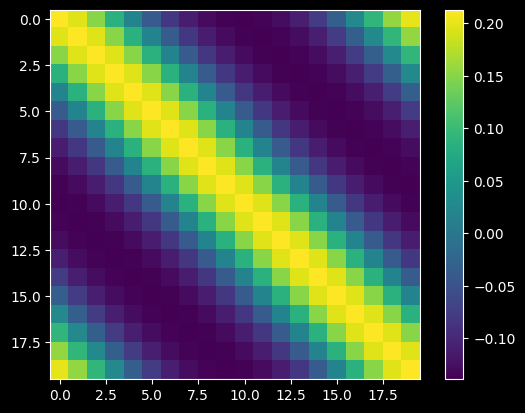

In [15]:
plt.imshow(K)
plt.colorbar()

## Predicting $\frac{df(x)}{dx}$

Let's predict on the training points to see whether the model has learned the derivatives correctly

In [16]:
pred = model.predict(d)

/home/e.cignoni/GPX/gpx/models/gpr.py:218: UserWarning: _grad01jac_kernelize is still experimental and not tested.
  K_mn = kernel(x_train, x, kernel_params)


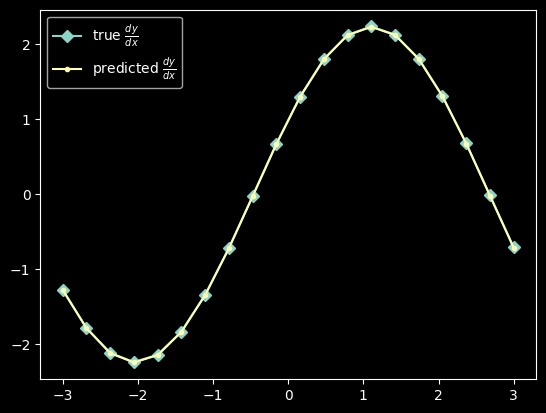

In [17]:
plt.plot(x, y, '-D', label=r'true $\frac{dy}{dx}$')
plt.plot(x, pred, '-o', label=r'predicted $\frac{dy}{dx}$', ms=3)
plt.legend()

## Predicting $f(x)$

We can also predict the values of $f(x)$ after having trained on its derivatives.
For this, we need a kernel that, on one side, is not derived. Let's create it with another kernelizer

In [18]:
from gpx.kernels.kernelizers import grad0_kernelize

kernel = grad0_kernelize(squared_exponential_kernel_base, with_jacob=True)
kernel = partial(kernel, jacobian=jac_d)

In [19]:
K = kernel(d, d, params=model.state.params['kernel_params'])

/tmp/ipykernel_15420/1079404700.py:1: UserWarning: _grad0jac_kernelize is still experimental and not tested.
  K = kernel(d, d, params=model.state.params['kernel_params'])


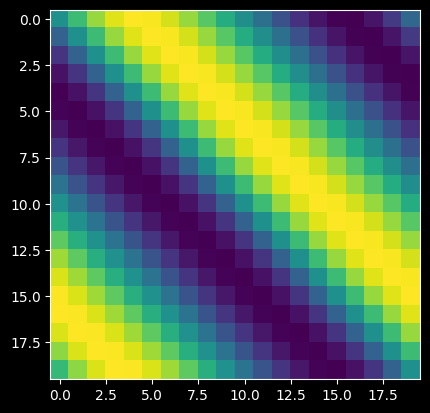

In [20]:
plt.imshow(K)

Again, since we do not have (yet) a model to train on derivatives, this requires a small hack

In [21]:
# these are the trained coefficients
model.c_.shape

(20, 1)

In [22]:
pred = jnp.einsum('ij,il->lj', model.c_, K)

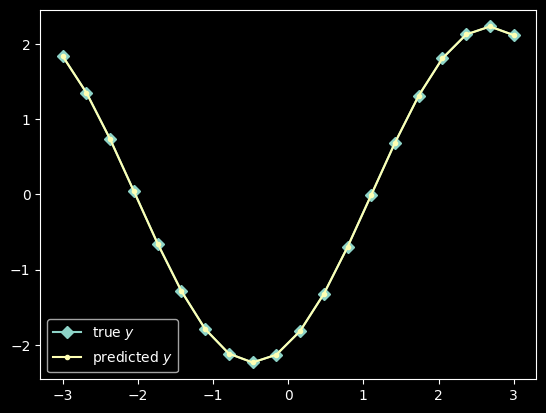

In [23]:
plt.plot(x, f_batched(x), '-D', label=r'true $y$')
plt.plot(x, pred, '-o', label=r'predicted $y$', ms=3)
plt.legend()

Note that, in general, there will be a rigid shift of the prediction, because the integration of our prediction to obtain $f(x)$ is defined modulo a constant.

## Predicting on test points

Let's create some other points and predict both $\frac{df(x)}{dx}$ and $f(x)$ on those

In [24]:
# new points
x_valid = jnp.linspace(3, 20, 50).reshape(-1, 1)

# their descriptors
d_valid = d_batched(x_valid)

# their jacobian
jac_d_valid = dd_dx_batched(x_valid)

Remember that, until we have the new model, we need to change the kernel function to make it accept a different jacobian

In [25]:
kernel = grad01_kernelize(squared_exponential_kernel_base, with_jacob=True)
kernel = partial(kernel, jacobian1=jac_d, jacobian2=jac_d_valid)

In [26]:
K = kernel(d, d_valid, params=model.state.params['kernel_params'])
pred = jnp.einsum('ij,il->lj', model.c_, K)

/tmp/ipykernel_15420/687507160.py:1: UserWarning: _grad01jac_kernelize is still experimental and not tested.
  K = kernel(d, d_valid, params=model.state.params['kernel_params'])


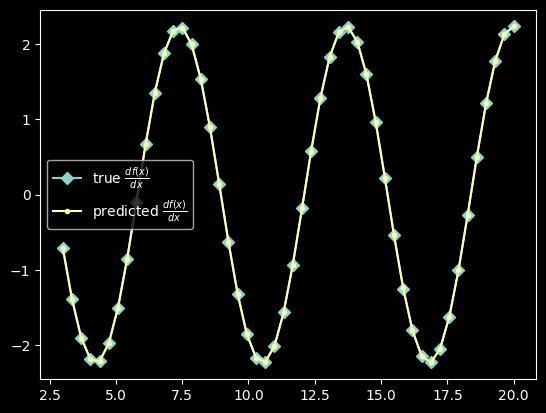

In [27]:
plt.plot(x_valid, df_dx_batched(x_valid).squeeze(), '-D', label=r'true $\frac{df(x)}{dx}$')
plt.plot(x_valid, pred, '-o', label=r'predicted $\frac{df(x)}{dx}$', ms=3)
plt.legend()

This prediction is really good because are are basically cheating by using our descriptor

We can also predict $f(x)$ values

In [28]:
kernel = grad0_kernelize(squared_exponential_kernel_base, with_jacob=True)
kernel = partial(kernel, jacobian=jac_d)

In [29]:
K = kernel(d, d_valid, params=model.state.params['kernel_params'])
pred = jnp.einsum('ij,il->lj', model.c_, K)

/tmp/ipykernel_15420/687507160.py:1: UserWarning: _grad0jac_kernelize is still experimental and not tested.
  K = kernel(d, d_valid, params=model.state.params['kernel_params'])


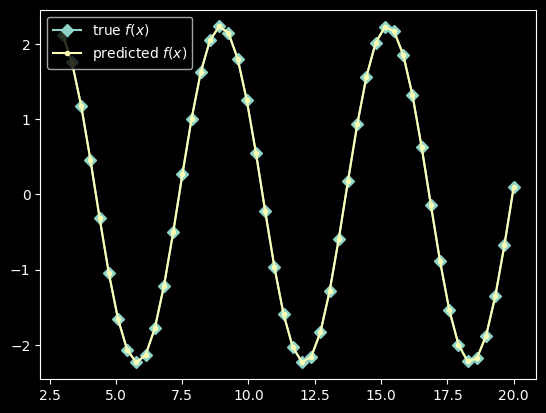

In [30]:
plt.plot(x_valid, f_batched(x_valid).squeeze(), '-D', label=r'true $f(x)$')
plt.plot(x_valid, pred, '-o', label=r'predicted $f(x)$', ms=3)
plt.legend()